# 프로젝트: 데이터 증강 기법 (CutMix, Mixup) 비교 실험

**1. 프로젝트 목적**:  
    
데이터 증강 기법이 Fine-grained 이미지 분류 성능에 미치는 영향을 비교 분석한다.  





**2. 데이터셋: [Stanford Dogs](http://vision.stanford.edu/aditya86/ImageNetDogs/main.html) 🐶**  
- 120개 견종, 약 20,580장의 이미지로 구성된 fine-grained 이미지 분류 벤치마크 데이터셋
- ImageNet의 개 카테고리를 세분화하여 구축된 데이터셋으로, 견종 간 시각적 유사성이 높아 분류 난이도가 높음 (fine-grained image classification)





**3. 모델: Pre-trained ResNet-50**  
- 사전 학습 가중치 이: ImageNet-1K (weights='IMAGENET1K_V1')
- 전이 학습(Transfer Learning) 적용 이유:
    * ImageNet으로 사전 학습된 저수준/고수준 feature 활용으로 학습 효율성 향상
    * ImageNet으로 사전 학습된 저수준/고수준 feature 활용으로 학습 효율성 향상
    * 작은 데이터셋에서도 안정적인 수렴 가능




**4. 성능 평가 지표**  
- Loss: Cross-Entropy Loss (다중 클래스 분류 최적화)
- Top-1 Accuracy: 모델의 최상위 예측이 정답과 일치하는 비율
- Top-5 Accuracy: 모델의 상위 5개 예측 내 정답 포함 비율

  *Fine-grained classification의 특성상 시각적으로 유사한 클래스 간 혼동이 빈번하여, Top-5 정확도가 모델의 실질적 구분 능력을 평가하는 데 유용  





**5. 증강 기법 구성**
- No Augmentation: 정규화 등 기본 전처리만 적용
- Basic Augmentation: 무작위 좌우 반전 밝기 변화 적용
- Basic + Mixup: Basic + 두 이미지의 선형 보간
- Basic + CutMix: Basic + 이미지 패치 교체 기반 증강

## 1. 라이브러리 불러오기 & 경로 설정

In [1]:
# Pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.amp import GradScaler, autocast # 학습 속도 가속

# Helper libraries
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tarfile
import scipy.io # .mat 파일을 읽기 위해 필요
import random
import time # 에폭별 학습 시간 측정을 위해 필요

In [2]:
# 이미지 데이터 압축 파일 경로
LISTS_TAR_PATH = './lists.tar'
DOGS_TAR_PATH = './stanford_dogs.tar' 

# 압축을 해제할 대상 디렉토리
EXTRACT_PATH = './stanford_dogs' 

# 데이터셋 클래스에서 참조할 최종 경로 설정
IMAGES_DIR = os.path.join(EXTRACT_PATH, 'Images') 
LISTS_DIR = os.path.join(EXTRACT_PATH, 'lists')

# TRAIN/TEST 파일의 전체 경로
TRAIN_LIST_PATH = os.path.join(LISTS_DIR, 'train_list.mat')
TEST_LIST_PATH = os.path.join(LISTS_DIR, 'test_list.mat')

# 모델 저장 경로
SAVE_DIR = './checkpoints'

# 필요한 폴더 미리 생성
os.makedirs(IMAGES_DIR, exist_ok=True) # 이미지 폴더
os.makedirs(LISTS_DIR, exist_ok=True) # 리스트 폴더
os.makedirs('./checkpoints', exist_ok=True) # 모델 저장 경로

## 2. 함수 & 클래스 정의

### 2-1. 함수 정의

In [3]:
def extract_data(tar_file_path, folder_name, extract_to, prefix=''): # 기본 prefix를 ''로 변경
    target_dir = os.path.join(extract_to, folder_name)

    if not os.path.exists(target_dir) or not os.listdir(target_dir):
        print(f"📦 압축 해제 중: {tar_file_path} -> {target_dir}")

        if not os.path.exists(tar_file_path):
            print(f"❌ 오류: {tar_file_path} 파일이 없습니다.")
            return
        
        try:
            with tarfile.open(tar_file_path, 'r') as tar:
                members = []
                for member in tar.getmembers():
                    if member.path.startswith(prefix):
                        member.name = member.path.replace(prefix, '', 1)
                        members.append(member)
                
                #압축 해제 경로를 target_dir로 지정
                # 경고 메시지를 없애기 위해 filter='data'를 명시적으로 추가
                tar.extractall(path=target_dir, members=members, filter='data') 
            print(f"✅ {folder_name} 압축 해제 완료.")
        except Exception as e:
            print(f"❌ 오류 발생: {e}")
    else:
        print(f"ℹ️ {folder_name} 데이터가 이미 존재합니다. 건너뜁니다.")

In [4]:
def show_sample_images(data_dir, num_samples=5):
    # 클래스(견종) 폴더 목록 가져오기
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    plt.figure(figsize=(16, 4))
    
    for i in range(num_samples):
        # 랜덤 견종 및 이미지 선택
        random_class = random.choice(classes)
        class_path = os.path.join(data_dir, random_class)
        random_img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, random_img_name)
        
        # 이미지 로드 및 출력
        img = Image.open(img_path)
        breed_name = random_class.split('-', 1)[-1] # 'n02085620-Chihuahua' -> 'Chihuahua'
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"{breed_name}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [5]:
def denormalize(tensor):
    """
    시각화를 위한 역정규화(Denormalize) 함수
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (tensor * std + mean).clamp(0, 1)

In [6]:
# top-k accuracy 평가 지표 계산 함수
def accuracy(output, target, topk=(1, 5)):
    with torch.no_grad():
        maxk = max(topk)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        
         # soft label(mixup/cutmix)인 경우 인덱스로 변환
        if target.ndimension() > 1:
            target = target.argmax(dim=1)

        correct = pred.eq(target.view(1, -1).expand_as(pred))
        
        # 총 정답 개수 반환
        return [correct[:k].reshape(-1).float().sum(0) for k in topk]

In [7]:
# Mixup 기법 구현
def apply_mixup(images, labels, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(images.size(0))

    mixed_images = lam * images + (1 - lam) * images[index, :]
    
    # 수정: labels[index, :] -> labels[index] (1차원이므로)
    # 수정: 정수형 레이블을 연산을 위해 float으로 변환
    mixed_labels = lam * labels.float() + (1 - lam) * labels[index].float()
    
    return mixed_images, mixed_labels, lam

In [8]:
# CutMix 기법 구현
def apply_cutmix(images, labels, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    index = torch.randperm(images.size(0))
    
    W, H = images.size(2), images.size(3)

    cut_rat = np.sqrt(1. - lam)
    cut_w, cut_h = int(W * cut_rat), int(H * cut_rat)

    cx, cy = np.random.randint(W), np.random.randint(H)

    bbx1, bby1 = np.clip(cx - cut_w // 2, 0, W), np.clip(cy - cut_h // 2, 0, H)
    bbx2, bby2 = np.clip(cx + cut_w // 2, 0, W), np.clip(cy + cut_h // 2, 0, H)

    images[:, :, bbx1:bbx2, bby1:bby2] = images[index, :, bbx1:bbx2, bby1:bby2]
    
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))

    # 수정: labels[index, :] -> labels[index] 및 float 변환
    mixed_labels = lam * labels.float() + (1 - lam) * labels[index].float()
    
    return images, mixed_labels, lam

In [9]:
def run_experiment(exp_name, train_loader, val_loader, save_dir, aug_type=None, alpha=1.0):
    os.makedirs(save_dir, exist_ok=True)
    filename = f'best_model_{exp_name.replace(" ", "_")}.pth'
    save_path = os.path.join(save_dir, filename)
    print(f"\n🚀 Starting Experiment: {exp_name}")
    
    model = models.resnet50(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # history에 train 지표 추가
    history = {
        'train_loss': [],
        'train_top1': [],
        'train_top5': [],
        'val_loss': [],
        'val_top1': [],
        'val_top5': [],
        'time': []
    }
    best_acc = 0.0
    
    # GradScaler 인스턴스 생성
    scaler = torch.amp.GradScaler('cuda')
    
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        
        # ============ Training ============
        model.train()
        running_loss = 0.0
        train_t1_acc, train_t5_acc, train_total = 0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            labels = labels.long()
            
            # 원본 labels 저장 (accuracy 계산용)
            original_labels = labels.clone()
            
            # 증강 기법에 따라 원핫 인코딩 여부를 결정
            if aug_type in ['mixup', 'cutmix']:
                labels_oh = torch.nn.functional.one_hot(labels, NUM_CLASSES).float()
                if aug_type == 'mixup':
                    images, target, _ = apply_mixup(images, labels_oh, alpha)
                elif aug_type == 'cutmix':
                    images, target, _ = apply_cutmix(images, labels_oh, alpha)
            else:
                # No Aug, Basic Aug일 때는 원본 labels를 target으로 설정
                target = labels
                
            optimizer.zero_grad()
            
            # autocast 컨텍스트 매니저 안에서 순전파 실행 (AMP 적용)
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, target)
            
            # 역전파 및 가중치 업데이트 시 scaler 사용
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update() 
            
            running_loss += loss.item() * images.size(0)
            
            # Training accuracy 계산 (원본 labels 기준)
            # Mixup/CutMix의 경우에도 원본 레이블로 정확도 측정
            with torch.no_grad():
                acc1, acc5 = accuracy(outputs, original_labels)
                train_t1_acc += acc1.item()
                train_t5_acc += acc5.item()
                train_total += original_labels.size(0)
        
        # Training 지표 계산
        train_loss = running_loss / len(train_loader.dataset)
        train_top1 = (train_t1_acc / train_total) * 100
        train_top5 = (train_t5_acc / train_total) * 100
        
        # ============ Validation ============
        model.eval()
        val_running_loss = 0.0
        val_t1_acc, val_t5_acc, val_total = 0, 0, 0
        
        with torch.no_grad():
            # 메모리 절약을 위해 gradient 계산 방지
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                
                # Validation loss 계산
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                
                # Validation accuracy 계산
                acc1, acc5 = accuracy(outputs, labels)
                val_t1_acc += acc1.item()
                val_t5_acc += acc5.item()
                val_total += labels.size(0)
        
        # Validation 지표 계산
        val_loss = val_running_loss / len(val_loader.dataset)
        val_top1 = (val_t1_acc / val_total) * 100
        val_top5 = (val_t5_acc / val_total) * 100
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        
        # History 기록
        history['train_loss'].append(train_loss)
        history['train_top1'].append(train_top1)
        history['train_top5'].append(train_top5)
        history['val_loss'].append(val_loss)
        history['val_top1'].append(val_top1)
        history['val_top5'].append(val_top5)
        history['time'].append(epoch_duration)
        
        # 출력 (Train + Val 함께)
        print(f"Epoch [{epoch+1}/{EPOCHS}]: "
              f"Train Loss {train_loss:.4f} | Train Top-1 {train_top1:.2f}% | Train Top-5 {train_top5:.2f}% | "
              f"Val Loss {val_loss:.4f} | Val Top-1 {val_top1:.2f}% | Val Top-5 {val_top5:.2f}% | "
              f"Time {epoch_duration:.1f}s")
        
        # Best model 저장 (validation top-1 기준)
        if val_top1 > best_acc:
            best_acc = val_top1
            torch.save(model.state_dict(), save_path)
            print(f"   >>> ★ New best model saved: {filename}")
        
    return history

In [10]:
def visualize_results(all_histories):
    """
    Train/Val 결과 시각화
    """
    # 1. 요약 표 생성
    summary_data = []
    for exp_name, hist in all_histories.items():
        best_train_top1 = max(hist['train_top1'])
        best_val_top1 = max(hist['val_top1'])
        overfit_gap = best_train_top1 - best_val_top1  # 과적합 지표
        
        summary_data.append({
            'Augmentation': exp_name,
            'Best Train Loss': f"{min(hist['train_loss']):.6f}",
            'Best Val Loss': f"{min(hist['val_loss']):.6f}",
            'Best Train Top-1 (%)': f"{best_train_top1:.2f}",
            'Best Val Top-1 (%)': f"{best_val_top1:.2f}",
            'Best Val Top-5 (%)': f"{max(hist['val_top5']):.2f}",
            'Overfit Gap (%)': f"{overfit_gap:.2f}"  # Train-Val 차이
        })
    
    df_summary = pd.DataFrame(summary_data)
    print("\n" + "="*100)
    print("📊 실험 결과 요약 (Summary Table)")
    print("="*100)
    print(df_summary.to_string(index=False))
    print("="*100)
    print("💡 Overfit Gap: Train Top-1 - Val Top-1 (클수록 과적합 심함)")
    print("="*100)
    
    # 2. 그래프 시각화
    first_hist = next(iter(all_histories.values()))
    epochs = range(1, len(first_hist['val_top1']) + 1)
    
    # 2x3 그리드: 상단(Train), 하단(Val)
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # ============ Row 1: Training 지표 ============
    # Loss
    for exp_name, hist in all_histories.items():
        axes[0, 0].plot(epochs, hist['train_loss'], marker='o', markersize=4, label=exp_name)
    axes[0, 0].set_title('Training Loss', fontsize=13, fontweight='bold')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, linestyle='--', alpha=0.7)
    axes[0, 0].legend()
    
    # Top-1 Accuracy
    for exp_name, hist in all_histories.items():
        axes[0, 1].plot(epochs, hist['train_top1'], marker='s', markersize=4, label=exp_name)
    axes[0, 1].set_title('Training Top-1 Accuracy', fontsize=13, fontweight='bold')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].grid(True, linestyle='--', alpha=0.7)
    axes[0, 1].legend()
    
    # Top-5 Accuracy
    for exp_name, hist in all_histories.items():
        axes[0, 2].plot(epochs, hist['train_top5'], marker='^', markersize=4, label=exp_name)
    axes[0, 2].set_title('Training Top-5 Accuracy', fontsize=13, fontweight='bold')
    axes[0, 2].set_xlabel('Epochs')
    axes[0, 2].set_ylabel('Accuracy (%)')
    axes[0, 2].grid(True, linestyle='--', alpha=0.7)
    axes[0, 2].legend()
    
    # ============ Row 2: Validation 지표 ============
    # Loss
    for exp_name, hist in all_histories.items():
        axes[1, 0].plot(epochs, hist['val_loss'], marker='o', markersize=4, label=exp_name)
    axes[1, 0].set_title('Validation Loss', fontsize=13, fontweight='bold')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True, linestyle='--', alpha=0.7)
    axes[1, 0].legend()
    
    # Top-1 Accuracy
    for exp_name, hist in all_histories.items():
        axes[1, 1].plot(epochs, hist['val_top1'], marker='s', markersize=4, label=exp_name)
    axes[1, 1].set_title('Validation Top-1 Accuracy', fontsize=13, fontweight='bold')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].grid(True, linestyle='--', alpha=0.7)
    axes[1, 1].legend()
    
    # Top-5 Accuracy
    for exp_name, hist in all_histories.items():
        axes[1, 2].plot(epochs, hist['val_top5'], marker='^', markersize=4, label=exp_name)
    axes[1, 2].set_title('Validation Top-5 Accuracy', fontsize=13, fontweight='bold')
    axes[1, 2].set_xlabel('Epochs')
    axes[1, 2].set_ylabel('Accuracy (%)')
    axes[1, 2].grid(True, linestyle='--', alpha=0.7)
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()

### 2-2. 클래스 정의

In [11]:
class StanfordDogsDataset(Dataset):
    """
    데이터셋 인스턴스를 생성하는 클래스
    """
    def __init__(self, img_dir, list_path, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # mat 파일 읽기
        mat_data = scipy.io.loadmat(list_path)

        # 파일 경로 추출 (중첩 구조 해제)
        # mat_data['file_list'] 안의 각 요소는 array(['경로']) 형태이므로 [0][0]으로 문자열만 추출
        file_list = [f[0][0] for f in mat_data['file_list']]

        # 레이블 추출 및 0부터 시작하도록 인덱스 조정 (-1)
        labels = mat_data['labels'].flatten() - 1

        # 데이터프레임 생성
        self.img_labels = pd.DataFrame({
            'path': file_list,
            'label': labels
        })
        
        # 클래스 이름 매핑 (데이터프레임의 'path' 컬럼 활용)
        self.classes = sorted(list(set(p.split('/')[0] for p in self.img_labels['path'])))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # 이미지 파일의 전체 경로 생성
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        
        return image, label

## 3. 데이터 불러오기

In [12]:
# Images 폴더 추출
extract_data(
    tar_file_path=DOGS_TAR_PATH, 
    folder_name='Images', 
    extract_to=EXTRACT_PATH,
    prefix=''
)

extract_data(
    tar_file_path=LISTS_TAR_PATH, 
    folder_name='lists', 
    extract_to=EXTRACT_PATH, # 이 경로는 함수 내에서 target_dir에 합쳐짐
    prefix='' 
)

ℹ️ Images 데이터가 이미 존재합니다. 건너뜁니다.
ℹ️ lists 데이터가 이미 존재합니다. 건너뜁니다.


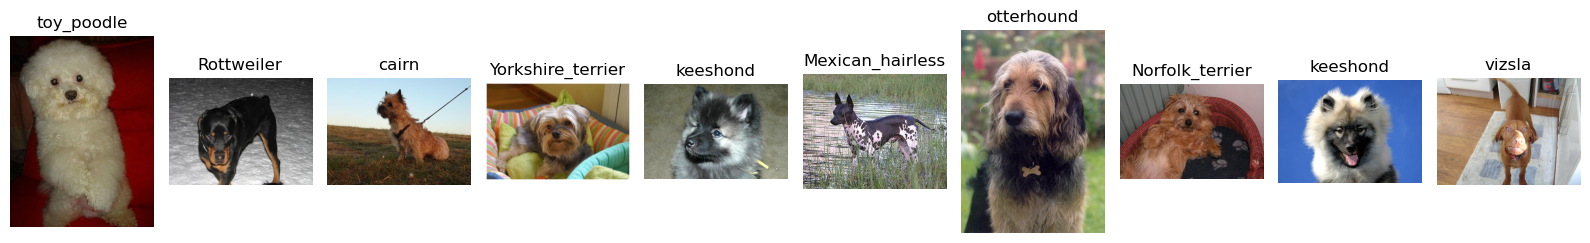

In [13]:
# 샘플 이미지 출력
show_sample_images(IMAGES_DIR, 10)

In [14]:
# 데이터 전처리 설정 -> 데이터 인스턴스에 전달
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2),
        transforms.ToTensor(), # 텐서로 변환 (0~1 범위)
        transforms.Lambda(lambda x: torch.clamp(x, 0, 1)), # 안전장치로 clamp 설정
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ResNet 전용 정규화 값
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [15]:
# 데이터셋 인스턴스 생성
train_dataset = StanfordDogsDataset(
    img_dir=IMAGES_DIR,
    list_path=TRAIN_LIST_PATH,
    transform=data_transforms['train']
)

val_dataset = StanfordDogsDataset(
    img_dir=IMAGES_DIR, 
    list_path=TEST_LIST_PATH, 
    transform=data_transforms['val']
)

print(f"✅ 학습 데이터: {len(train_dataset)}개 | 검증 데이터: {len(val_dataset)}개") # Sanity check

✅ 학습 데이터: 12000개 | 검증 데이터: 8580개


## 4. 증강 기법 시각화

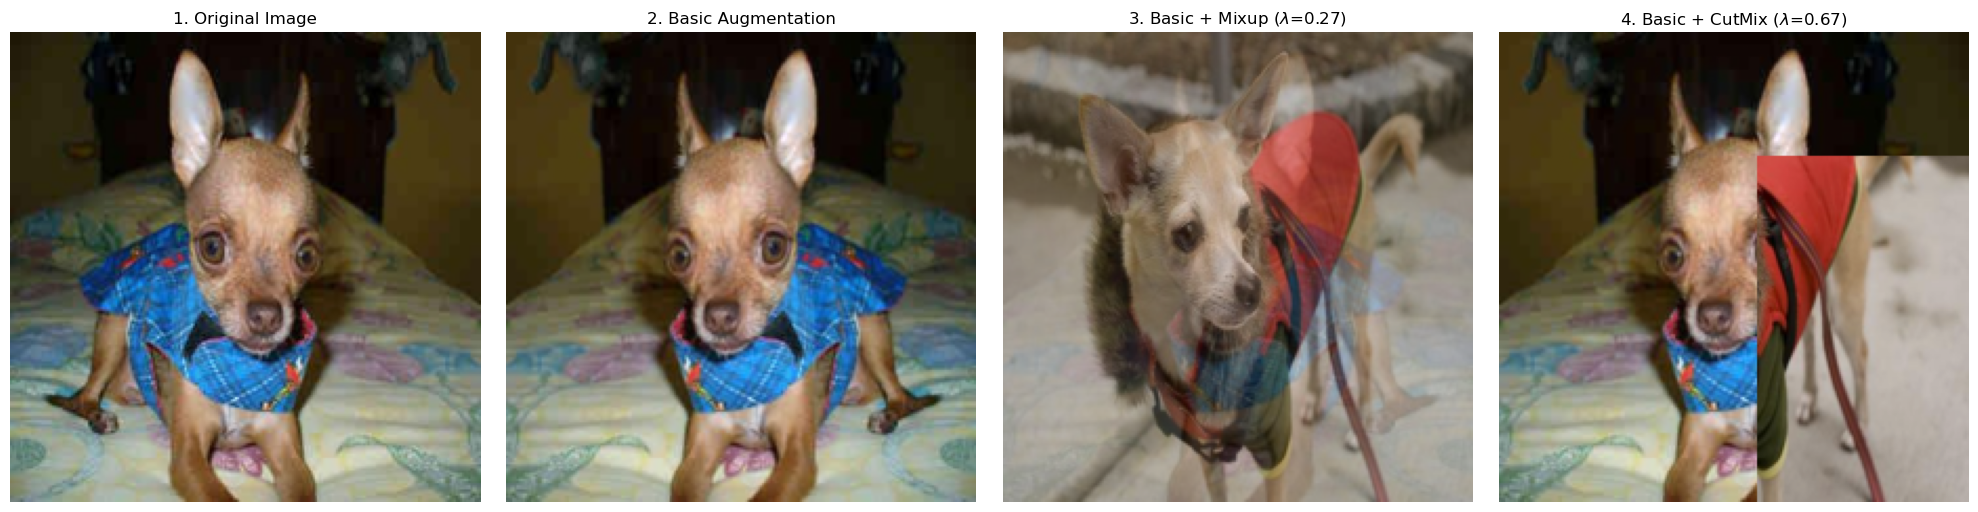

In [20]:
# 시각화할 인덱스 고정
TARGET_IDX = 0 
BATCH_SIZE = 8

# 원본 이미지 파일 경로 가져오기
row = train_dataset.img_labels.iloc[TARGET_IDX]
img_filename = row.iloc[0] # .iloc로 위치 기반 접근 명시
sample_path = os.path.join(train_dataset.img_dir, img_filename)

# Case 1: 원본 (Transform 적용 전)
raw_img_pil = Image.open(sample_path).convert('RGB').resize((224, 224))

# DataLoader에서 배치 가져오기 (이미 Standard Aug 적용됨)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False) # Shuffle 끄기
images_batch, labels_batch = next(iter(train_loader))

# Case2: 배치 가져올 때 이미 적용됨

# Case 3: 기본 증강 + Mixup (기본 증강 적용된 배치에 apply_mixup 함수 적용)
mixup_imgs, _, lam_mix = apply_mixup(images_batch.clone(), labels_batch, alpha=0.85) # 원본 보존을 위해 .clone() 사용

# Case 4: 기본 증강 + CutMix (기본 증강 적용된 배치에 apply_cutmix 함수 적용)
cutmix_imgs, _, lam_cut = apply_cutmix(images_batch.clone(), labels_batch, alpha=0.85)

# 시각화
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(raw_img_pil)
plt.title("1. Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(denormalize(images_batch[TARGET_IDX]).permute(1, 2, 0).cpu())
plt.title("2. Basic Augmentation")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(denormalize(mixup_imgs[TARGET_IDX]).permute(1, 2, 0).cpu())
plt.title(fr"3. Basic + Mixup ($\lambda$={lam_mix:.2f})")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(denormalize(cutmix_imgs[TARGET_IDX]).permute(1, 2, 0).cpu())
plt.title(fr"4. Basic + CutMix ($\lambda$={lam_cut:.2f})")
plt.axis('off')

plt.tight_layout()
plt.show()

## 5. 실험 진행

In [21]:
# 하이퍼파라미터 및 장치 설정
NUM_CLASSES = 120
BATCH_SIZE = 32 # 컨테이너 메모리 용량 부족으로 작게 설정
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda



🔬 STARTING ALL EXPERIMENTS
📊 Total Experiments: 4
📊 Epochs per Experiment: 10
📊 Batch Size: 32
📊 Device: cuda
📊 Training Samples: 12000
📊 Validation Samples: 8580

🧪 Experiment 1/4: No Aug
📝 Transform: Using 'val' (No Augmentation)
📝 Additional Augmentation: None
📦 Train Batches: 375
📦 Val Batches: 269
--------------------------------------------------------------------------------

🚀 Starting Experiment: No Aug
Epoch [1/10]: Train Loss 1.9755 | Train Top-1 56.29% | Train Top-5 85.14% | Val Loss 1.0295 | Val Top-1 71.04% | Val Top-5 95.10% | Time 74.9s
   >>> ★ New best model saved: best_model_No_Aug.pth
Epoch [2/10]: Train Loss 0.6562 | Train Top-1 81.60% | Train Top-5 98.54% | Val Loss 0.9152 | Val Top-1 72.56% | Val Top-5 95.63% | Time 74.7s
   >>> ★ New best model saved: best_model_No_Aug.pth
Epoch [3/10]: Train Loss 0.3210 | Train Top-1 91.36% | Train Top-5 99.74% | Val Loss 0.9303 | Val Top-1 72.72% | Val Top-5 95.78% | Time 74.5s
   >>> ★ New best model saved: best_model_No_Aug

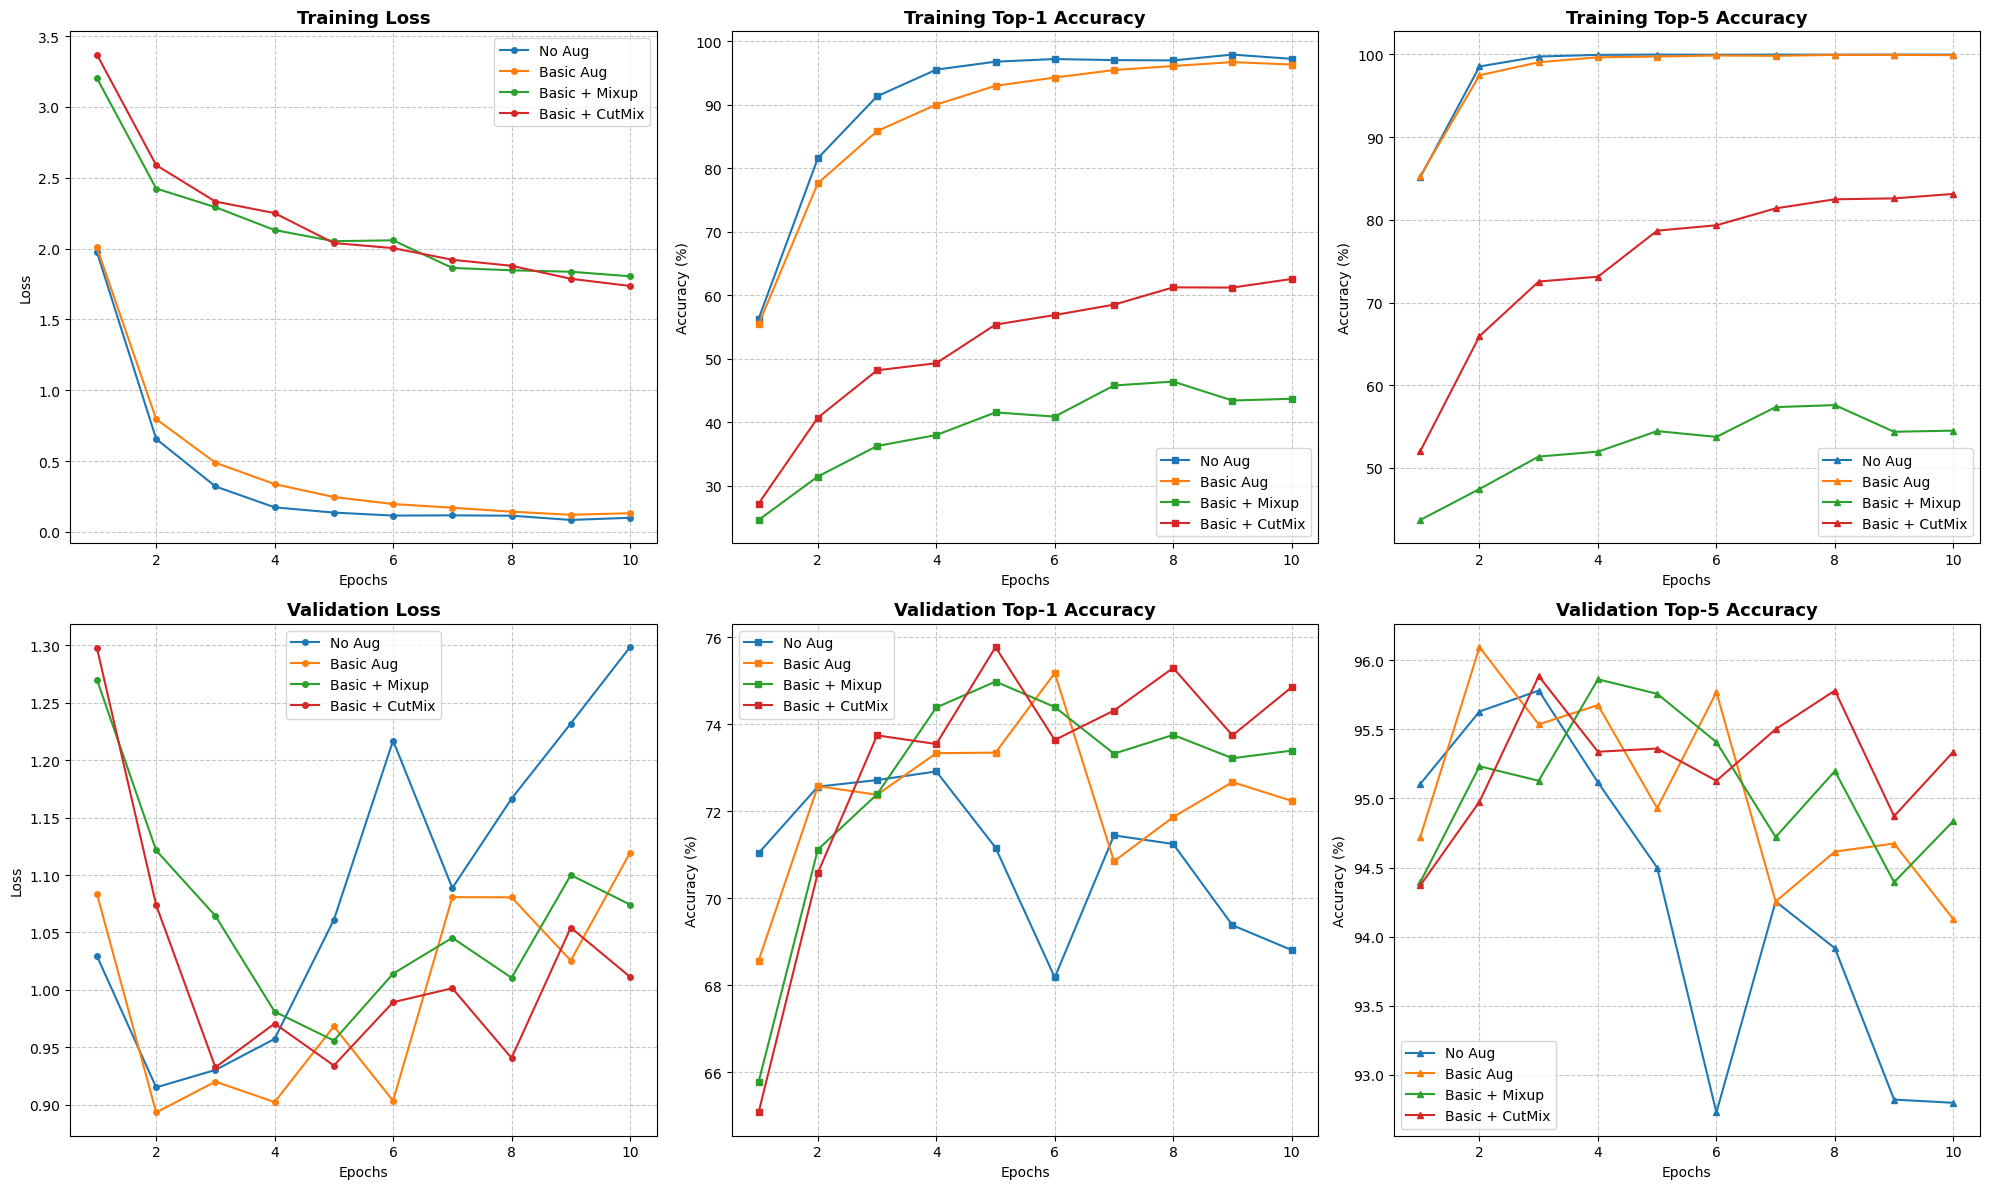

✅ Visualization completed!

🏁 EXPERIMENT PIPELINE FINISHED


In [24]:
# 학습을 위해 데이터셋 새로 생성
train_data = StanfordDogsDataset(
    img_dir=IMAGES_DIR,
    list_path=TRAIN_LIST_PATH,
    transform=data_transforms['train']  # 기본값은 train
                                        # 위에서 정의한 transformation 재사용
)
val_data = StanfordDogsDataset(
    img_dir=IMAGES_DIR, 
    list_path=TEST_LIST_PATH, 
    transform=data_transforms['val']
)

# Validation DataLoader는 한 번만 생성 (모든 실험에서 공통)
val_loader = DataLoader(
    val_data, 
    batch_size=BATCH_SIZE, 
    num_workers=2, 
    pin_memory=True,
    shuffle=False  # validation은 섞을 필요 없음
)

# 실험 설정
configs = [
    ('No Aug', None, 1.0),
    ('Basic Aug', None, 1.0),
    ('Basic + Mixup', 'mixup', 0.85),
    ('Basic + CutMix', 'cutmix', 0.85)
]

# 결과 저장용 딕셔너리
results = {}

# 초기 캐시 삭제
torch.cuda.empty_cache()

# 실험 시작
print("\n" + "="*80)
print("🔬 STARTING ALL EXPERIMENTS")
print("="*80)
print(f"📊 Total Experiments: {len(configs)}")
print(f"📊 Epochs per Experiment: {EPOCHS}")
print(f"📊 Batch Size: {BATCH_SIZE}")
print(f"📊 Device: {DEVICE}")
print(f"📊 Training Samples: {len(train_data)}")
print(f"📊 Validation Samples: {len(val_data)}")
print("="*80)

for idx, (name, aug, alpha_val) in enumerate(configs, 1):
    print(f"\n{'='*80}")
    print(f"🧪 Experiment {idx}/{len(configs)}: {name}")
    print(f"{'='*80}")
    
    # No Aug일 때만 transform 변경
    if name == 'No Aug':
        # No Aug 실험: validation용 transform 사용 (증강 없음)
        train_data.transform = data_transforms['val']
        print("📝 Transform: Using 'val' (No Augmentation)")
    else:
        # 나머지 실험: training용 transform 사용 (Basic Aug 포함)
        train_data.transform = data_transforms['train']
        print("📝 Transform: Using 'train' (Basic Augmentation)")
    
    if aug:
        print(f"📝 Additional Augmentation: {aug.upper()} (alpha={alpha_val})")
    else:
        print("📝 Additional Augmentation: None")
    
    # Train DataLoader 생성 (transform이 변경되었으므로 매번 재생성 필요)
    train_loader = DataLoader(
        train_data, 
        batch_size=BATCH_SIZE, 
        shuffle=True,  # training은 항상 섞기
        num_workers=2, 
        pin_memory=True,
        drop_last=False  # 마지막 배치도 사용 (데이터가 적으면 유용)
    )
    
    print(f"📦 Train Batches: {len(train_loader)}")
    print(f"📦 Val Batches: {len(val_loader)}")
    print("-" * 80)
    
    # 실험 실행
    try:
        results[name] = run_experiment(
            exp_name=name, 
            train_loader=train_loader, 
            val_loader=val_loader, 
            save_dir=SAVE_DIR,
            aug_type=aug, 
            alpha=alpha_val
        )
        
        # 실험 종료 후 메모리 정리
        torch.cuda.empty_cache()
        print(f"\n✅ {name} completed and memory cleared")
        print(f"✅ Progress: {idx}/{len(configs)} experiments completed")
        
    except Exception as e:
        print(f"\n❌ Error in {name}: {str(e)}")
        print("❌ Skipping this experiment and continuing...")
        continue

# 모든 실험 완료
print("\n" + "="*80)
print("🎉 ALL EXPERIMENTS COMPLETED!")
print("="*80)
print(f"✅ Successfully completed: {len(results)}/{len(configs)} experiments")
print(f"✅ Results saved in: {SAVE_DIR}")
print("="*80)

# 결과 시각화
if len(results) > 0:
    print("\n📊 Generating visualization...")
    try:
        visualize_results(results)
        print("✅ Visualization completed!")
    except Exception as e:
        print(f"❌ Visualization failed: {str(e)}")
else:
    print("\n❌ No results to visualize (all experiments failed)")

print("\n" + "="*80)
print("🏁 EXPERIMENT PIPELINE FINISHED")
print("="*80)

## 6. 실험 결과

**1. 증강 기법별 Validation 성능 비교**  

`Basic + CutMix`가 Top-1 정확도 75.77%로 가장 높은 성능을 기록했으며, 이는 `No Augmentation`(72.91%) 대비 약 2.86%p 향상된 결과이다. `Basic + Mixup`(74.98%)과 `Basic Aug`(75.17%) 역시 베이스라인 대비 개선된 성능을 보였으나, 모든 증강 기법 간 성능 차이는 약 0.8%p 이내로 미미한 수준이었다.

**2. Loss vs. Accuracy**  

`Mixup/CutMix`는 soft label을 사용하는 특성상 높은 loss(1.74~1.80)를 보이지만, 실제 분류 정확도는 오히려 향상되었다. 이는 이 기법들이 절대적 확신(hard prediction)을 억제하면서도 판별력은 유지시키는 정칙화 효과를 내기 때문이라고 볼 수 있다.

**3. Basic Augmentation의 성능 재평가**  

`Basic Aug`는 `No Augmentation` 대비 2.26%p 개선(72.91% → 75.17%)을 보여 일정한 효과가 확인되었다. 다만 Basic + CutMix(75.77%)와의 차이는 0.6%p에 불과해, fine-grained classification에서는 공간 변환 증강(RandomHorizontalFlip, ColorJitter)도 유용하지만 샘플 간 혼합 증강(CutMix)을 추가하면 추가적인 성능 향상이 가능함을 알 수 있었다. 다만 실용적 차이는 제한적이다.

**4. 훈련 안정성**  
그래프를 보면 `No Augmentation`은 학습 초반(Epoch 4) 이후 급격히 성능이 하락하여 심한 과적합 발생했으나, `CutMix`는 최고 성능 이후 0.92%p만 하락하여 가장 안정적인 학습 곡선을 유지했다. 이는 증강 기법의 강도가 높을수록 과적합 억제 효과 증가함을 시사한다.  

추가로 train accuracy 또한 보면, `No Augmentation`의 경우 Train 97.92% 과 Val 72.91% 의 격차가 25.01%p까지 벌어졌으며, `Basic Aug`에서는 Train 96.75% vs Val 75.17%의 차이가 21.58%p 였다. `Mixup`이나`CutMix`는 측정 방식 특성상 train accuracy가 낮게 나오지만, validation 성능이 우수하여 실질적 과적합이 가장 적다.<br>
<br>
<br>
_*주의사항: Mixup/CutMix의 training Accuracy 해석_ 
_Mixup과 CutMix는 학습 시 soft label(혼합된 레이블)을 사용하지만, training accuracy 측정은 관행에 따라 원본 hard label을 기준으로 계산<br>_

## 7. 회고

- 이번 프로젝트를 수행하며 fine grained image classification이라는 또 하나의 분야를 알게 되었다.
- 간단한 조사를 하며 GeeksforGeeks 포스팅을 특히 흥미롭게 읽었다  ([link](https://www.geeksforgeeks.org/deep-learning/fine-grained-image-classification/)).
- 제한된 GPU 자원을 최대한 효율적으로 쓰기 위해 `BATCH_SIZE`도 조절해보고, `torch.amp` 라이브러리의 `GradScaler`와 `autocast`도 사용해보는 등 몇 가지 해결책을 적용했다. 여기서 1시간 10분 정도 걸리던 학습 시간을 더 단축하려면 또 어떤 방식을 취할 수 있을지 정말 궁금하다.
- 그래서 더 큰 데이터셋으로 20~30 epochs 정도 실험을 진행하면 증강 기법의 효과가 더 크지 않을까 싶다.